In [88]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Download Data

We're downloading the dialouge from all of Shakespeare's plays via Kaggle. The below cell contains what you'd run in your terminal, but to do so you need to have a Kaggle Account/API Key.

In [67]:
import subprocess
import sys
import os
# subprocess.run("kaggle datasets download -d kingburrito666/shakespeare-plays && unzip shakespeare-plays.zip",shell=True)
plays_df = pd.read_csv("Shakespeare_data.csv")
# Drop stage directions (where there isn't an act/scene/line)
plays_df = plays_df[pd.notna(plays_df['ActSceneLine'])]
plays_df[['Act','Scene','Line']] = plays_df['ActSceneLine'].str.split('.',expand = True).astype(float)
plays_df = plays_df.drop('ActSceneLine',axis=1)
# Standardize play casing
plays_df['Play'] = plays_df['Play'].apply(lambda x: x.title())
print("{} rows and {} columns".format(*plays_df.shape))
plays_df.head()

105153 rows and 8 columns


,Dataline,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
3,4,Henry Iv,1.0,KING HENRY IV,"So shaken as we are, so wan with care,",1.0,1.0,1.0
4,5,Henry Iv,1.0,KING HENRY IV,"Find we a time for frighted peace to pant,",1.0,1.0,2.0
5,6,Henry Iv,1.0,KING HENRY IV,And breathe short-winded accents of new broils,1.0,1.0,3.0
6,7,Henry Iv,1.0,KING HENRY IV,To be commenced in strands afar remote.,1.0,1.0,4.0
7,8,Henry Iv,1.0,KING HENRY IV,No more the thirsty entrance of this soil,1.0,1.0,5.0


All the plays we have to work with

In [22]:
play_list = plays_df["Play"].unique()
play_list

array(['Henry Iv', 'Henry Vi Part 1', 'Henry Vi Part 2',
       'Henry Vi Part 3', 'Alls Well That Ends Well', 'As You Like It',
       'Antony And Cleopatra', 'A Comedy Of Errors', 'Coriolanus',
       'Cymbeline', 'Hamlet', 'Henry V', 'Henry Viii', 'King John',
       'Julius Caesar', 'King Lear', 'Loves Labours Lost', 'Macbeth',
       'Measure For Measure', 'Merchant Of Venice',
       'Merry Wives Of Windsor', 'A Midsummer Nights Dream',
       'Much Ado About Nothing', 'Othello', 'Pericles', 'Richard Ii',
       'Richard Iii', 'Romeo And Juliet', 'Taming Of The Shrew',
       'The Tempest', 'Timon Of Athens', 'Titus Andronicus',
       'Troilus And Cressida', 'Twelfth Night', 'Two Gentlemen Of Verona',
       'A Winters Tale'], dtype=object)

In [39]:
play_name = "Merchant Of Venice"
single_play = plays_df[(plays_df['Play'] == play_name)]
single_play.head()

,Dataline,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
61366,61367,Merchant Of Venice,1.0,ANTONIO,"In sooth, I know not why I am so sad:",1.0,1.0,1.0
61367,61368,Merchant Of Venice,1.0,ANTONIO,"It wearies me, you say it wearies you,",1.0,1.0,2.0
61368,61369,Merchant Of Venice,1.0,ANTONIO,"But how I caught it, found it, or came by it,",1.0,1.0,3.0
61369,61370,Merchant Of Venice,1.0,ANTONIO,"What stuff 'tis made of, whereof it is born,",1.0,1.0,4.0
61370,61371,Merchant Of Venice,1.0,ANTONIO,"I am to learn,",1.0,1.0,5.0


## Organize play by act/scene and keep track of who speaks in which

In [71]:
# Group the play dataframe by each character to get how often they speak
top_characters = single_play.groupby(['Player']).size().reset_index()
top_characters.rename(columns = {0: 'Count'}, inplace = True)
# Get top 20 Characters
top_characters = top_characters.sort_values("Count",ascending=False).head(20)
top_characters

,Player,Count
15,PORTIA,589
19,SHYLOCK,355
4,BASSANIO,336
1,ANTONIO,189
12,LORENZO,179
8,GRATIANO,175
10,LAUNCELOT,168
17,SALARINO,104
13,MOROCCO,103
9,JESSICA,86


### Create Graph and add all the characters

In [100]:
character_graph = nx.Graph()
character_graph.add_nodes_from(top_characters["Player"])

### Go scene by scene and add links between all the characters who spoke in that scene

We're updating the weights as we go scene by scene so that  

In [105]:
from itertools import combinations
# Group the play by the Act/Scene and get how much each character spoke in that scene 
character_counts = single_play.groupby(['Act','Scene','Player']).size().reset_index()
character_counts = character_counts[character_counts["Player"].isin(top_characters["Player"])]
character_counts.rename(columns = {0: 'Count'}, inplace = True)

# Go scene by scene
for (act,scene), counts in character_counts.groupby(['Act','Scene']):
    # Get all the characters that are in that scene
    characters = counts["Player"].tolist()
    # If a scene contains characters [A,B,C] we want are graph to 
    # contain the edges [(A,B),(A,C),(B,C)]
    pairs = list(combinations(characters,2))
    for (a_char, b_char) in pairs:
        a_count = float(counts[counts["Player"] == a_char]["Count"])
        b_count = float(counts[counts["Player"] == b_char]["Count"])
        if character_graph.has_edge(a_char, b_char):
            # we added this one before, just increase the weight by one
            character_graph[a_char][b_char]['weight'] += 1
        else:
            # new edge. add with weight=1
            character_graph.add_edge(a_char, b_char, weight = a_count + b_count)

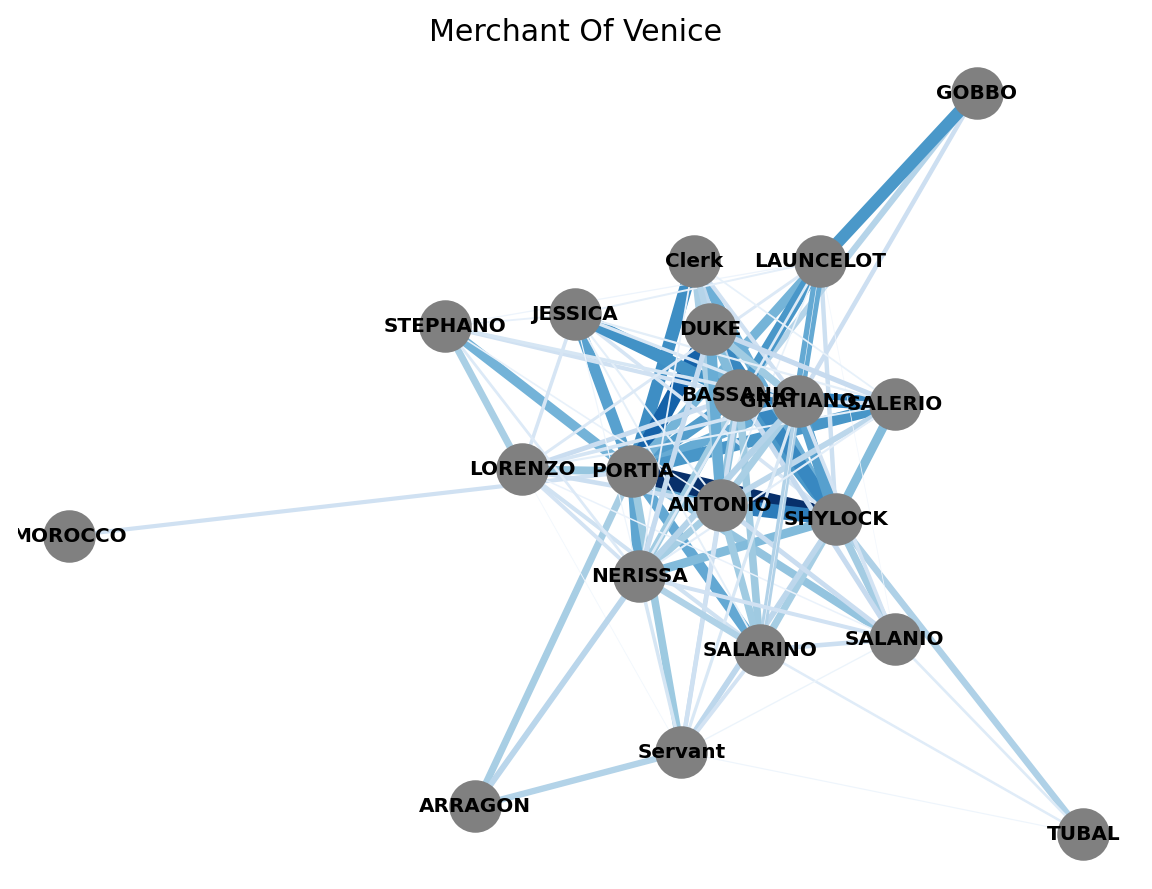

In [119]:
# drawing NX graph object
plt.figure(figsize = (8,6), dpi = 180)
plt.title(play_name)
    
pos = nx.spring_layout(character_graph)
# Divide all the weights by 30 so that the edges aren't super thick
weights = np.array([character_graph[u][v]['weight'] for u,v in character_graph.edges()])/30
kwargs = {
    "with_labels": True,
    "node_size": 400,
    "node_color": 'grey',
    "font_size": 8,
    "font_weight": 'semibold',
    "width": weights,
    "edge_color": weights, 
    "edge_cmap": plt.cm.Blues,
    "pos": pos
}
nx.draw_networkx(character_graph, **kwargs)

plt.axis('off')
plt.show()
plt.close()